In [21]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys
import collections

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
from sklearn.model_selection import ParameterGrid
import random
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment
from codelib.stats import weighted_kurtosis, weighted_skew

from codelib.plotting import dist_vs_normal_plot, volume_contribution_plot, DefaultStyle, default_colors
sns.set_theme("paper","whitegrid")
DefaultStyle()
"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Target Data

In [22]:
test_data = pd.read_parquet('abm_calibration/ef805fd82ff54fadb363094e3b122ab9.parquet', engine='pyarrow')
test_data
spy_prices = test_data[["time_id", "price"]]
spy_prices = spy_prices.set_index("time_id", drop = True)
spy_returns = (spy_prices["price"] / spy_prices["price"].shift() - 1).dropna()

acf_five_lags = acf(spy_returns, nlags = 5)[1:]
acf_abs_five_lags = acf(np.abs(spy_returns), nlags = 5)[1:]
kurtosis_target = weighted_kurtosis(spy_returns, wts = np.ones_like(spy_returns))

In [23]:
acf_five_lags = acf(spy_returns, nlags = 5)[1:]
acf_abs_five_lags = acf(np.abs(spy_returns), nlags = 5)[1:]
kurtosis_target = weighted_kurtosis(spy_returns, wts = np.ones_like(spy_returns))

In [24]:
print(acf_five_lags)
print(acf_abs_five_lags)
print(kurtosis_target)


[ 0.00251712 -0.00442819 -0.0095977  -0.00898606 -0.00864612]
[0.09457079 0.08755694 0.08746724 0.07518348 0.07358721]
429.8238822874232


# Simulation 


## Setup

In [33]:
excel_path = "abm_calibration/abm_calibration_results_2.xlsx"

##################################
# CALIBRATION MODEL
##################################


def loss(hat_matrix, target_vector, weights):
    stds = np.std(hat_matrix, axis = 0)
    means = np.average(hat_matrix, axis = 0)
    std_hat_matrix = (hat_matrix - means) / stds
    std_target_vector = (target_vector - means) / stds
    losses = (std_hat_matrix - std_target_vector)**2 @ weights
    return losses

time_periods = 500
n_episodes = 3
save_every = 100
n_lags = 5

kurt_target = kurtosis_target
acf_target = acf_five_lags
acf_abs_target = acf_abs_five_lags
target_vector = np.hstack((kurt_target, acf_target, acf_abs_target))  



n_params = 2 * n_lags + 1
w_acf = np.repeat(1/15, n_lags)
w_kurt = np.array([1/3])
weights = np.hstack((w_kurt, w_acf, w_acf))

##################################
# SETUP GRID
##################################


n_random_agents = [4] #[10, 15, 20, 25, 30]
n_trend_agents = [4] #[0, 2, 4, 6]
n_mm_agents =  [15] #[15, 20, 22, 25, 30]
n_flips = [3] #[2, 3, 4]
mm_spreads = [0.1] #[0.05, 0.15, 0.2, 0.3, 0.5]
#inv_volume = [5, 10, 15, 20]
inv_lambda = [0.01]

param_grid ={'n_random': n_random_agents, 
             'n_trend': n_trend_agents,
             'n_mm': n_mm_agents,
             'n_flips': n_flips, 
             'mm_spread': mm_spreads,
             #'inv_volume': inv_volume,
             'inv_lambda': inv_lambda}
                
grid = ParameterGrid(param_grid)

combinations = []
for n in list(param_grid.values()):
    combinations.append(len(n))
n_combinations = np.array(combinations).cumprod()[-1]





results = pd.DataFrame({"kurt": 0}, index = [0])

for lag in range(n_lags):
    results[f"acf_{lag+1}"] = 0
for lag in range(n_lags):
    results[f"acf_abs_{lag+1}"] = 0
    
od = collections.OrderedDict(sorted(param_grid.items()))
param_list = list(od.keys())
for theta in param_list:
    results[theta] = 0
    
##################################
##################################
# START CALIBRATION
##################################
##################################
param_counter = 0
for params in grid:
    kurt = 0
    acfs = np.zeros(n_lags)
    acfs_abs =  np.zeros(n_lags)
    
    param_counter += 1
    current_params = np.array(list(params.values()))
    
    ##################################
    # Declare parameters
    ##################################
    n_random_agents = params['n_random']
    n_investor_agents = 2
    n_trend_agents = params['n_trend']
    n_mm_agents = params['n_mm']
    n_rl_agents = 0
    spread_zero = params["mm_spread"]
    n_coin_flips = params["n_flips"]
    #inv_volumes = params["inv_volume"]
    inv_lambda = params["inv_lambda"]
    

    n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

    price_list = [100 + np.random.normal(scale = 0.01) for j in range(100)]
    ex_list = np.array([[0]*n_agents, [0]*n_agents])
    fee = 0
    slippage = 0
    mean_buy_price = 99.5
    mean_sell_price = 100.5
    delta = 1
    atp = 0

    state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
              "mean_sell_price": mean_sell_price, 'slippage': slippage, 'all_traded_prices': atp}

    agents = []

    investor_agents = []
    random_agents = []
    trend_agents = []
    mm_agents = []
    if n_investor_agents >= 1:
        investor_agents.append(InvestorAgent(agent_id = 0,
                                         delta = delta,
                                         intensity = inv_lambda,
                                         buy_price_margin = 0.0025,
                                         sell_price_margin = 0.010,
                                         buy_volume = 15,
                                         sell_volume = 30, 
                                         n_orders = 10))
    if n_investor_agents == 2:  
        investor_agents.append(InvestorAgent(agent_id = 1,
                                             delta = delta,
                                             intensity = inv_lambda / 2,
                                             n_orders = 6,
                                             buy_price_margin  = 0.005,
                                             sell_price_margin = 0.020,
                                             buy_volume = 25,
                                             sell_volume = 50,
                                             can_short = True))

    random_agents = [RandomAgent(agent_id = j + n_investor_agents,
                                 delta = delta,
                                 noise_range = (0.0001, 0.0003),
                                 mid_price_noise = 0.0025,
                                 n_coin_flips = n_coin_flips,  # PARAMETER
                                 coin_bias_sell = 0.5,
                                 coin_bias_buy = 0.5) for j in range(n_random_agents)]

    trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                     delta = delta,
                                      moving_average_one = np.random.randint(10, 30),
                                      moving_average_two = np.random.randint(50, 100),
                                      price_margin = 0.005) for j in range(n_trend_agents)]

    mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                                  delta = delta,
                                  gamma = 0.00005,
                                  gamma2 = np.random.randint(1, 3),
                                  spread_zero = spread_zero,   # PARAMETER
                                  n_volume = 6) for j in range(n_mm_agents)]

    rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + mm_agents,
                                     delta = delta) for j in range(n_rl_agents)]

    agents.append(investor_agents)
    agents.append(random_agents)
    agents.append(trend_agents)
    agents.append(mm_agents)
    agents.append(rl_agents)
    
    ##################################
    # INIT ENVIRONMENT AND AGENTS
    ##################################
    env = MarketEnvironment(state0, use_last_traded_price = True)

    agents = [item for sublist in agents for item in sublist]

    # Initialize agents
    for j in range(n_agents):
        agents[j].update(state0)
        
    ##################################
    # START SIMULATION
    ##################################


    rl_profit = []
    market_prices = []
    inv1_pos = []
    inv2_pos = []
    market_volume = []
    
    stack_autocorrels = True


    #fig, ax = plt.subplots(3, 1, figsize = (12, 6))
    #fig.tight_layout()
    for episode in range(n_episodes):
        atps = np.array([np.nan])
        env = MarketEnvironment(state0, use_last_traded_price = True)
        # Initialize agents
        for j in range(n_agents):
                agents[j].reset()
                agents[j].update(state0)

        # START EPISODE
        for time in range(time_periods):

            agents, state = env.step(agents)

            for j in range(n_agents):
                agents[j].update(state)


            ########################################
            # PRINT RUNTIME
            ########################################
            sys.stdout.write('\r\r\r\r\r')
            sys.stdout.write('\r\r\r\r\r')
            j = (time + 1) / time_periods
            sys.stdout.write('\r'.center(65))
            sys.stdout.write(f"PARAM COUNT {param_counter} / {n_combinations} EPISODE {episode} - %d%%".center(65) % (100*j))
            sys.stdout.flush()


            #########################################
            # UPDATE PLOTS
            #########################################

            inv1_pos.append(agents[0].position)
            inv2_pos.append(agents[1].position)
            market_volume.append(state["volume"])
            market_prices.append(state["market_prices"][-1])
            atps = np.hstack((atps, state["all_traded_prices"]))

        #########################################
        # Update calibration target estimates
        #########################################

        mp = pd.DataFrame(atps)
        returns = (mp / mp.shift(1)  - 1).dropna()

        kurt += weighted_kurtosis(returns, wts=np.ones_like(returns)) / n_episodes
        acfs += acf(returns, nlags = n_lags)[1:] / n_episodes
        acfs_abs += acf(np.abs(returns), nlags = n_lags)[1:] / n_episodes


    hat_vector = np.hstack((kurt, acfs, acfs_abs))

    new_row = np.hstack((kurt, acfs, acfs_abs, current_params))
    new_row_df = pd.DataFrame(new_row).T
    new_row_df.columns = results.columns

    results = results.append(new_row_df, ignore_index = True)

    #############################################
    # Save params
    #############################################
    if param_counter % save_every == 0:
        hat_matrix = results.values[:, :len(weights)]
        loss_values = loss(hat_matrix, target_vector, weights)
        results_temp = results.copy()
        results_temp["loss"] = loss_values
        results_temp.to_excel(f"{excel_path}", engine = "openpyxl")
        
# save final params
results_temp = results.copy()
hat_matrix = results.values[:, :len(weights)]
loss_values = loss(hat_matrix, target_vector, weights)
results_temp["loss"] = loss_values
results_temp.to_excel(f"{excel_path}", engine = "openpyxl")

                                                PARAM COUNT 1 / 1 EPISODE 2 - 100%               

In [30]:
kurt

104.09779232115685

## Run simulation

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Cumulative Return')]

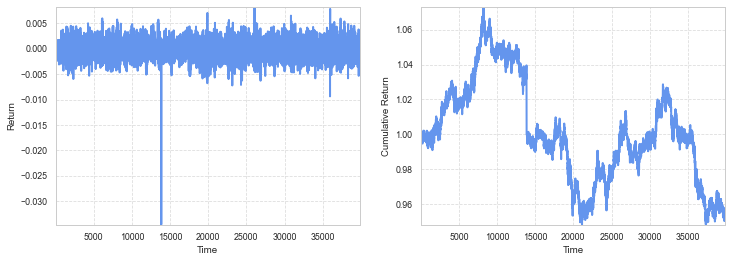

In [31]:
#mp = pd.DataFrame(market_prices[100:])
mp = pd.DataFrame(atps)

returns = (mp / mp.shift(1)  - 1).dropna()
#returns = returns[abs(returns.values) <= 0.0125]
cum_ret = (returns + 1).cumprod()
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(ylabel = "Return", xlabel = "Time")
ax[1].plot(cum_ret)
ax[1].set(xlabel = "Time", ylabel = "Cumulative Return")

#plt.savefig("plots/returns_cumreturns_4.png")

# Stylized Facts Comparison

### Heavy Tails

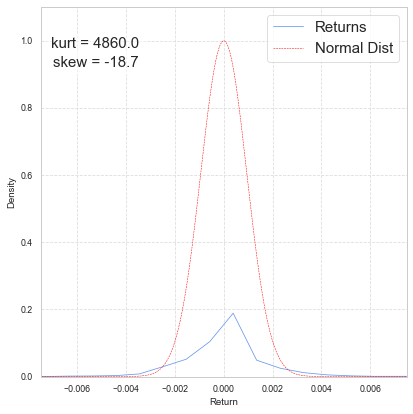

In [8]:
fig, ax = plt.subplots(figsize = (6, 6))
dist_vs_normal_plot(returns, ax = ax)
#dist_vs_normal(pd.DataFrame(all_stacked_returns), ax = ax)

fig.tight_layout()
#heavy_name = "heavy_tails_bfrl_4"
#plt.savefig(f"plots/{heavy_name}.png")

### Volatility Clustering

[(0.0, 41.0),
 (-0.25, 1.0),
 Text(0.5, 1.0, ''),
 Text(0.5, 14.7, 'Lag'),
 Text(19.575000000000003, 0.5, 'Autocorrelation')]

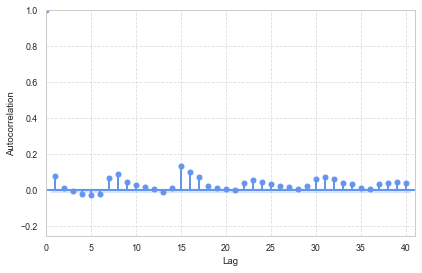

In [11]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(np.abs(returns[1:]), lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 41), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
#vol_clust_name = "vol_cluster_bfrl_4"
#plt.savefig(f"plots/{vol_clust_name}.png")

### Autocorrel of returns

[(0.0, 41.0),
 (-0.25, 1.0),
 Text(0.5, 1.0, ''),
 Text(0.5, 14.7, 'Lag'),
 Text(19.575000000000003, 0.5, 'Autocorrelation')]

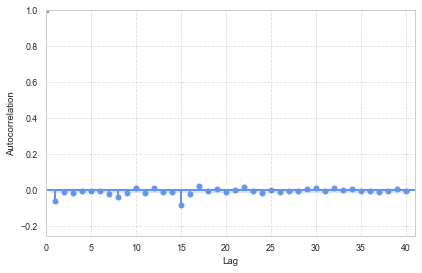

In [12]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(returns[1:], lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 41), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
#vol_clust_name = "vol_cluster_bfrl_4"
#plt.savefig(f"plots/{vol_clust_name}.png")
#auto_ret_name = "auto_returns_bfrl_4"
#plt.savefig(f"plots/{auto_ret_name}.png")

# Volume Contribution

NameError: name 'time_points' is not defined

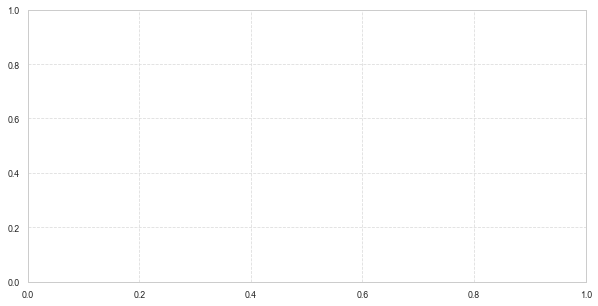

In [13]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points, stacked_volumes, ax = ax)
#volume_name = "volume_graph_4"
#plt.savefig(f"plots/{volume_name}.png")

In [35]:
len(time_points)

100

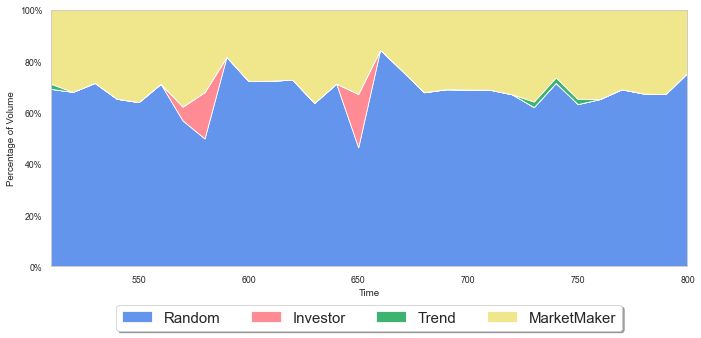

In [36]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points[50:80], stacked_volumes[:, 50:80], ax = ax)
fig.tight_layout()
volume_name_zoom = "volume_graph_zoom_4"
#plt.savefig(f"plots/{volume_name_zoom}.png")

## Test MMS

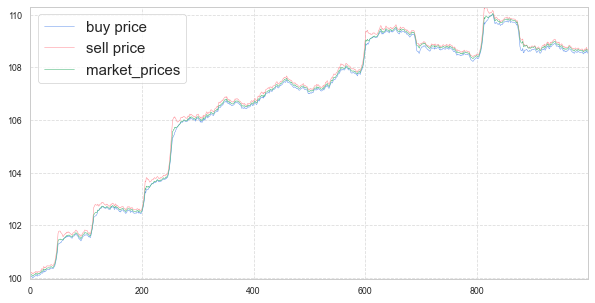

In [13]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(bps, label = "buy price", lw = 0.5)
ax.plot(sps, label = "sell price", lw = 0.5)
ax.plot(state["market_prices"][100:], label = "market_prices", lw = 0.5)
ax.legend()
#ax.set_xlim(200, 250)
#ax.set_ylim(108, 110)

<AxesSubplot:>

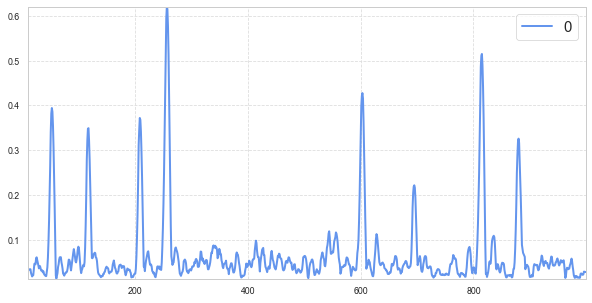

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
pd.DataFrame(state["market_prices"][100:]).rolling(window = 10).std().plot(ax = ax)

# PnL

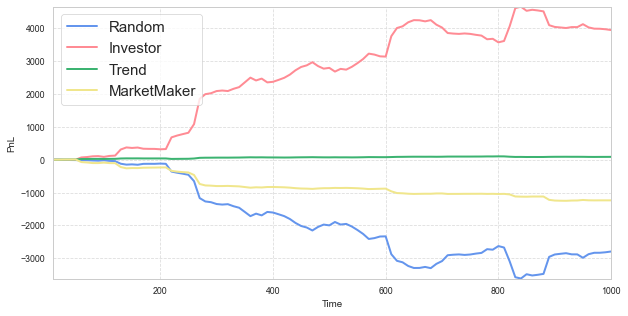

In [15]:
fig, ax = plt.subplots(figsize = (10, 5))
labs = ["Random", "Investor", "Trend", "MarketMaker"]
for j in range(4):
    ax.plot(time_points, stacked_pnls[j, :], label = labs[j])
ax.set(xlabel = "Time", ylabel = "PnL")
ax.legend()

# Performance overview

In [45]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -5.343281372915953e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
30,30,MM,3.0,-68.539122,0.508333
35,35,MM,3.0,-109.818973,0.534366
43,43,MM,4.0,-53.154131,0.542505
31,31,MM,4.0,-89.231790,0.543184
27,27,MM,3.0,-25.412543,0.549776
28,28,MM,2.0,-76.138978,0.589769
44,44,MM,5.0,-94.919661,0.626480
37,37,MM,2.0,-106.911924,0.629812
26,26,MM,4.0,-90.689244,0.686926
42,42,MM,2.0,-111.020548,0.716290


class
Investor    521.838246
MM          -77.589594
Random       19.759788
Trend        37.639876
Name: PNL, dtype: float64